Tree models dataset shape: (7043, 25)
Linear models dataset shape: (7043, 16)

Churn distribution in tree dataset:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn distribution in linear dataset:
Churn
0    5174
1    1869
Name: count, dtype: int64

Tree models - Training set shape: (5634, 24)
Tree models - Test set shape: (1409, 24)
Linear models - Training set shape: (5634, 15)
Linear models - Test set shape: (1409, 15)

After SMOTE:
Tree models - Training set shape: (8278, 24)
Linear models - Training set shape: (8278, 15)

=== Training logistic_regression ===
Using dataset with shape: (8278, 15)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score: 0.8346
Test ROC AUC: 0.8369
Test PR AUC: 0.6475

=== Training random_forest ===
Using dataset with shape: (8278, 24)
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'class_weight': None, 'max_depth': 20, 'min_

,Model,ROC AUC,PR AUC,F1 Score,Precision,Recall,Accuracy
0,logistic_regression,0.8369,0.6475,0.6151,0.4928,0.8182,0.7282
1,random_forest,0.8277,0.6204,0.6058,0.5558,0.6658,0.7700
2,xgboost,0.8060,0.5747,0.5918,0.5260,0.6765,0.7523


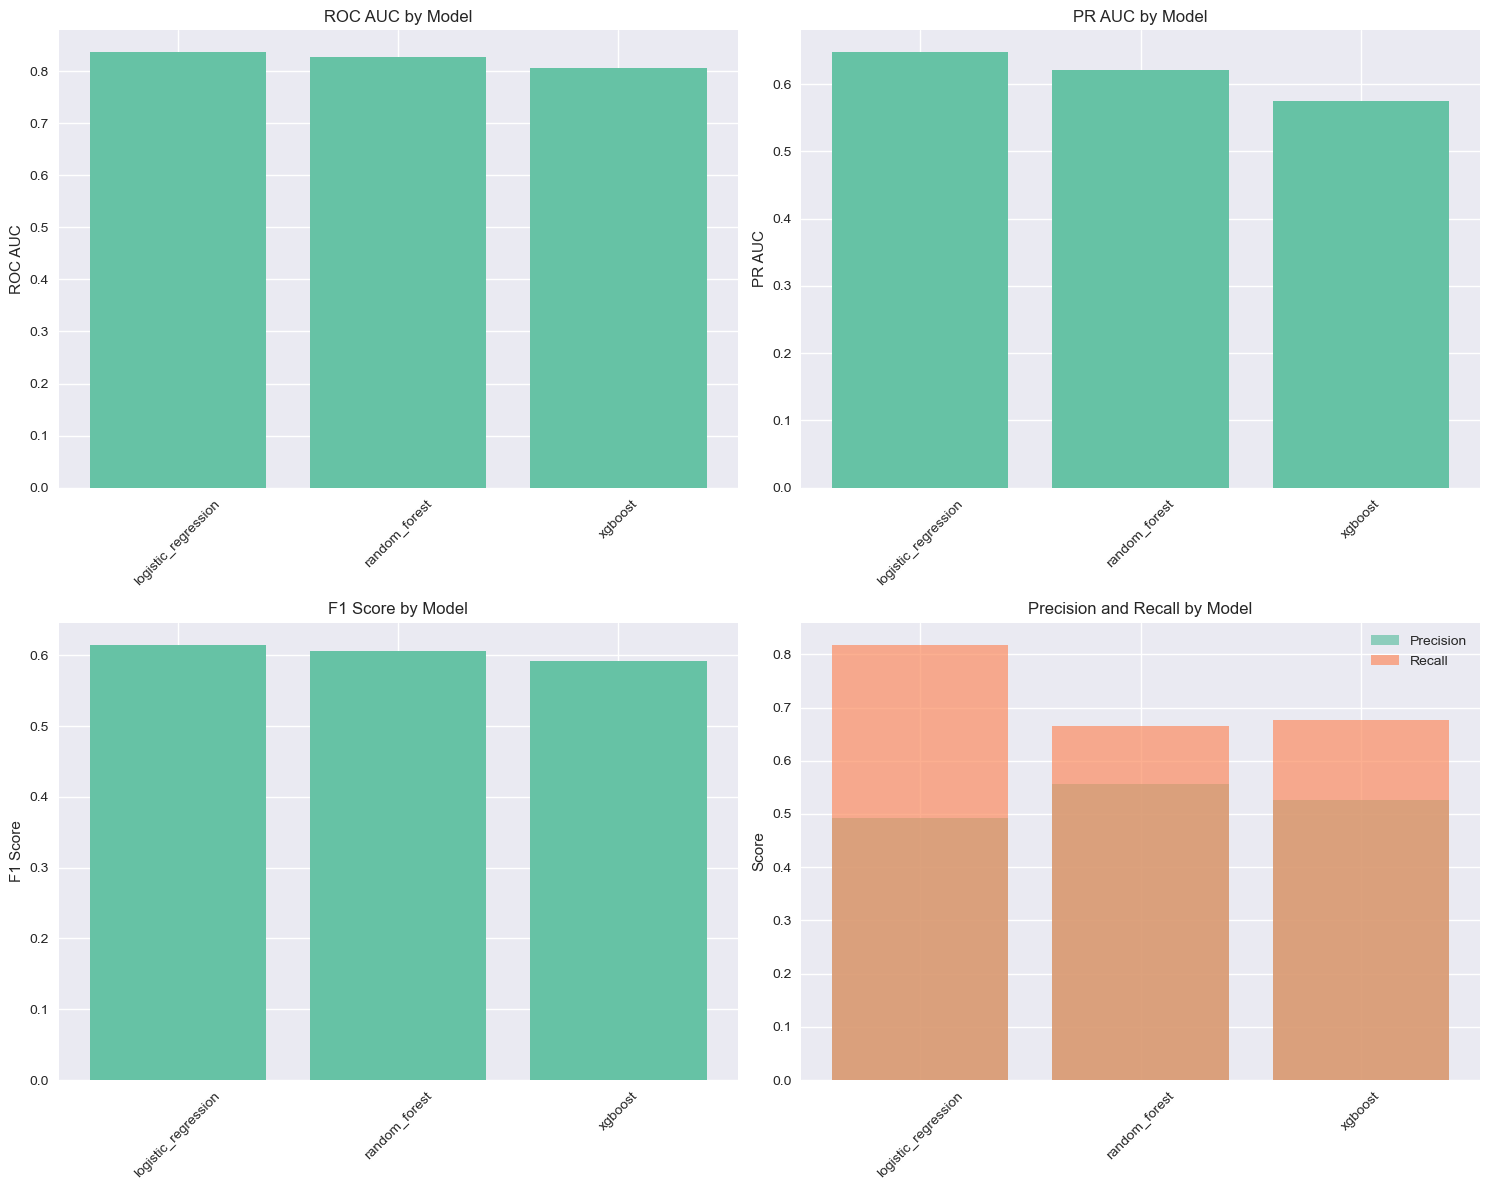

Best model: logistic_regression
PR AUC: 0.6475
ROC AUC: 0.8369

Classification Report:
              precision  recall  f1-score   support
0                0.9137  0.6957    0.7899 1035.0000
1                0.4928  0.8182    0.6151  374.0000
accuracy         0.7282  0.7282    0.7282    0.7282
macro avg        0.7032  0.7569    0.7025 1409.0000
weighted avg     0.8020  0.7282    0.7435 1409.0000


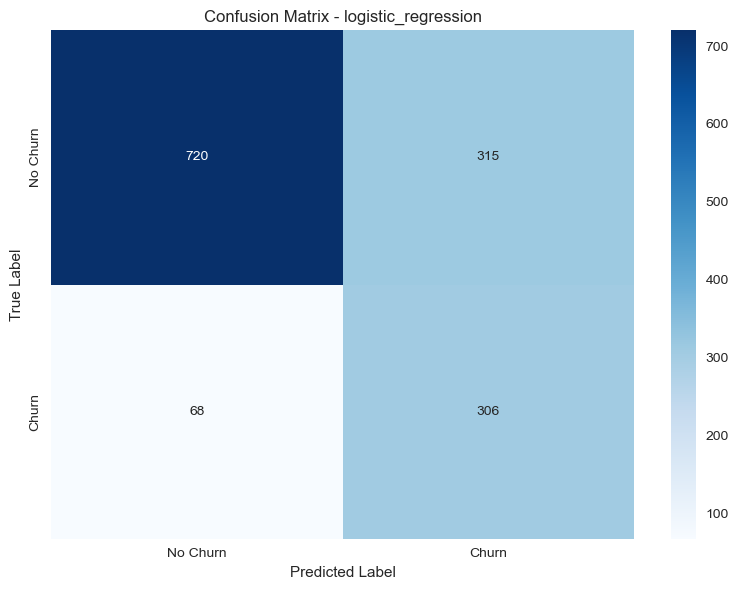

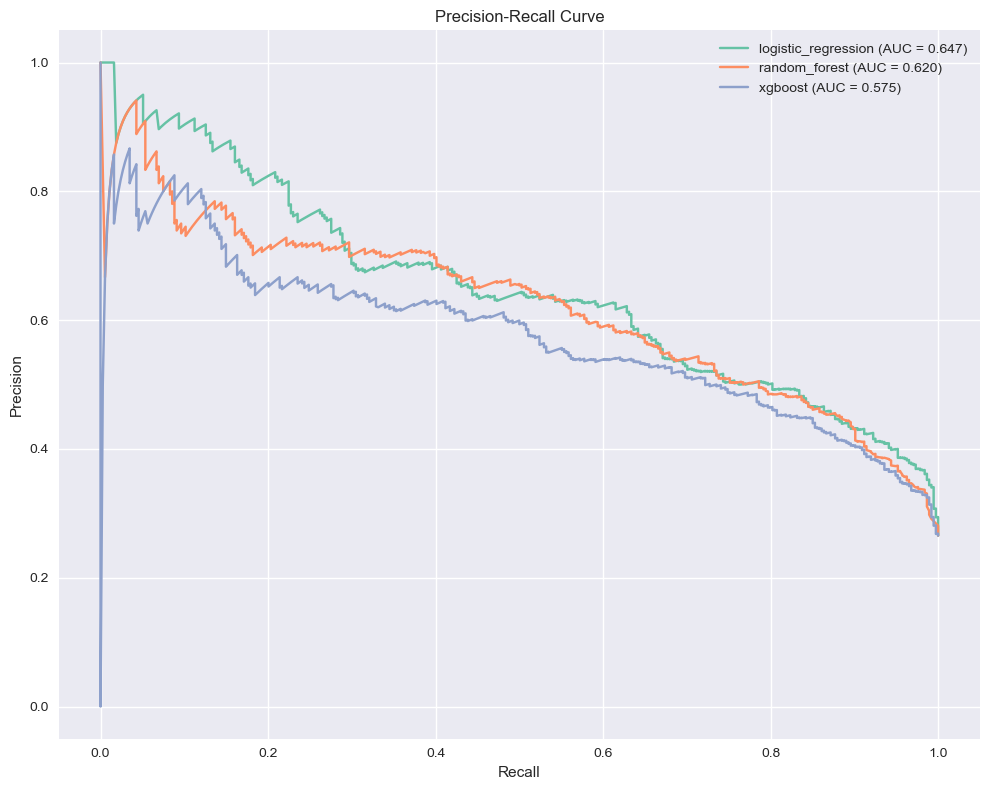

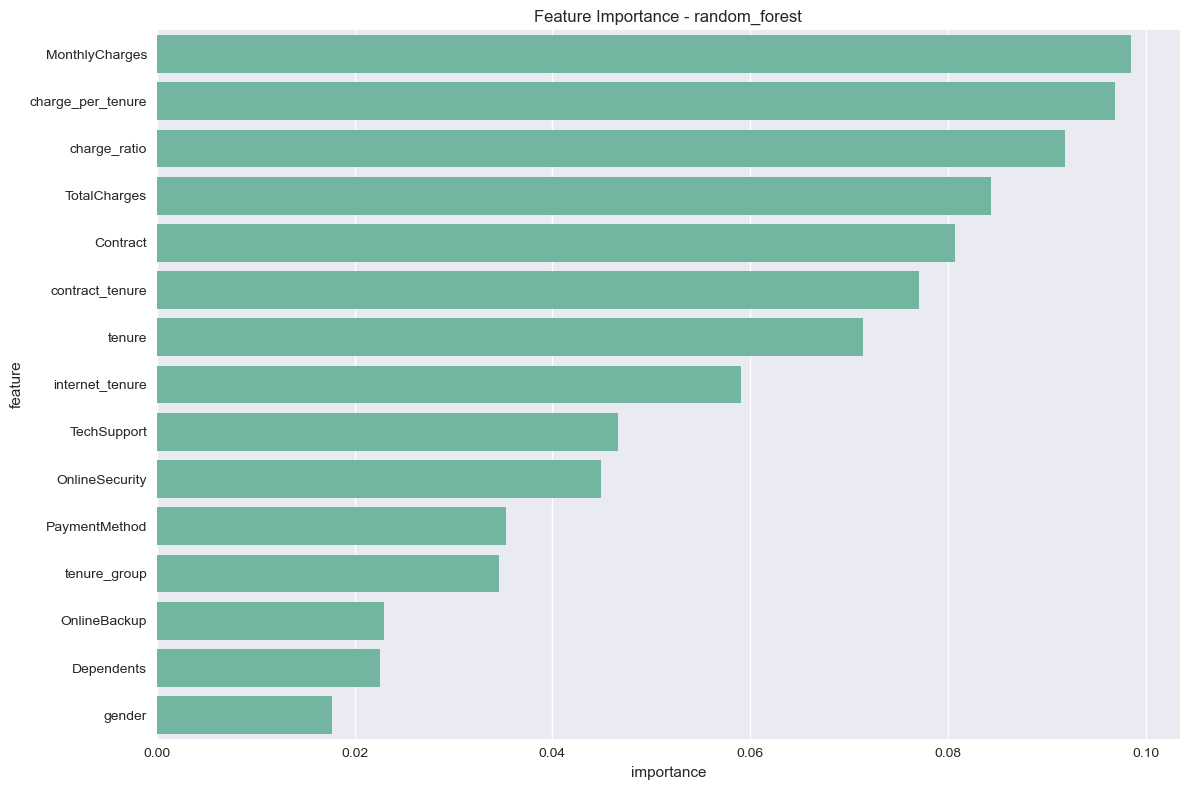

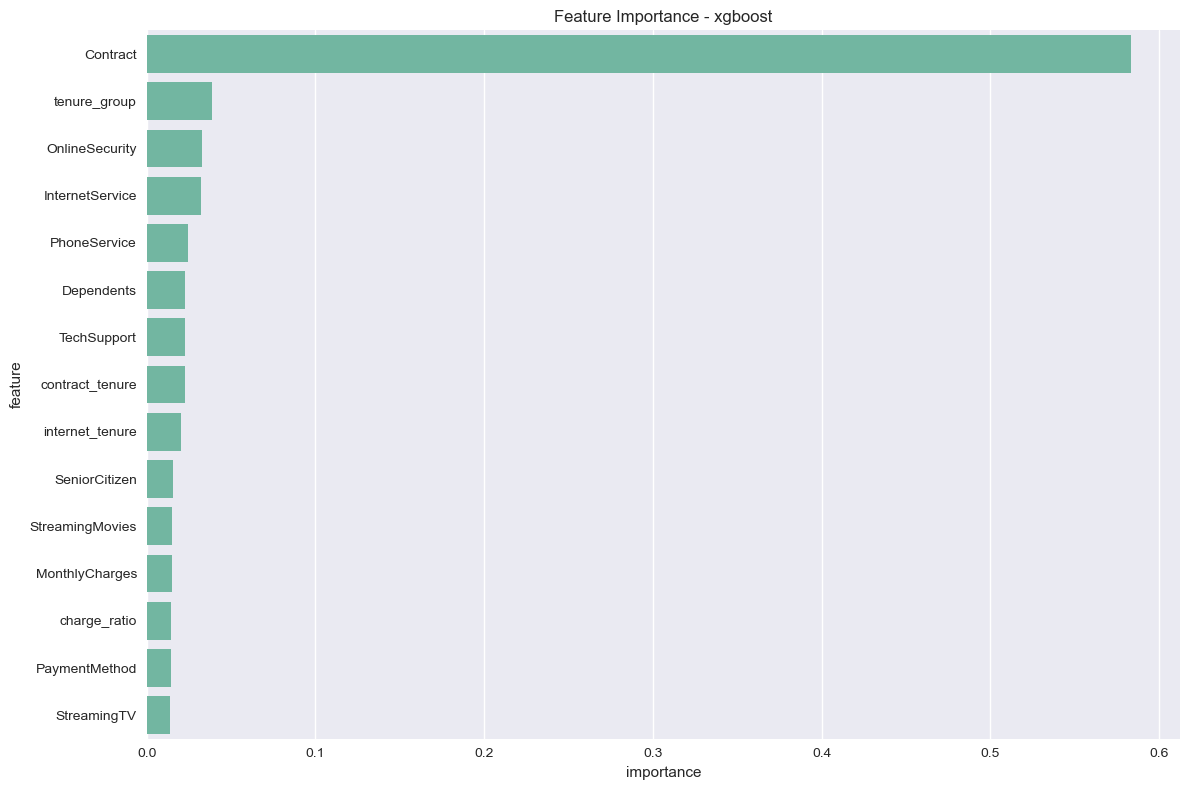

Best model saved to '../models/best_model_logistic_regression.pkl'
All model results saved to '../models/all_model_results.pkl'
Model comparison saved to '../results/model_comparison.csv'


In [6]:
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# # Customer Churn Prediction - Model Training
# 
# This notebook focuses on training and evaluating multiple models for churn prediction.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, precision_recall_curve, auc,
                             f1_score, precision_score, recall_score, accuracy_score)
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
%matplotlib inline

# ## Load Processed Datasets

# Load tree models dataset (label encoded)
df_tree = pd.read_csv('../data/processed/telco_churn_tree_models.csv')
print("Tree models dataset shape:", df_tree.shape)

# Load linear models dataset (one-hot encoded)
df_linear = pd.read_csv('../data/processed/telco_churn_linear_models.csv')
print("Linear models dataset shape:", df_linear.shape)

# Check churn distribution
print("\nChurn distribution in tree dataset:")
print(df_tree['Churn'].value_counts())
print("\nChurn distribution in linear dataset:")
print(df_linear['Churn'].value_counts())

# ## Prepare Datasets for Specific Models

# For tree-based models (Random Forest, XGBoost) - use label encoded data
X_tree = df_tree.drop('Churn', axis=1)
y_tree = df_tree['Churn']

# For linear model (Logistic Regression) - use one-hot encoded data
X_linear = df_linear.drop('Churn', axis=1)
y_linear = df_linear['Churn']

# Split the data for each model type
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42, stratify=y_tree
)

X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=42, stratify=y_linear
)

print("\nTree models - Training set shape:", X_tree_train.shape)
print("Tree models - Test set shape:", X_tree_test.shape)
print("Linear models - Training set shape:", X_linear_train.shape)
print("Linear models - Test set shape:", X_linear_test.shape)

# ## Handle Class Imbalance

# Apply SMOTE to training data only for each dataset
smote = SMOTE(random_state=42)

# For tree models
X_tree_train_res, y_tree_train_res = smote.fit_resample(X_tree_train, y_tree_train)

# For linear models  
X_linear_train_res, y_linear_train_res = smote.fit_resample(X_linear_train, y_linear_train)

print("\nAfter SMOTE:")
print("Tree models - Training set shape:", X_tree_train_res.shape)
print("Linear models - Training set shape:", X_linear_train_res.shape)

# ## Model Training Setup

# Define models with their respective datasets
models = {
    'logistic_regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga'],
            'penalty': ['l1', 'l2']
        },
        'X_train': X_linear_train_res,
        'y_train': y_linear_train_res,
        'X_test': X_linear_test,
        'y_test': y_linear_test
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'class_weight': ['balanced', None]
        },
        'X_train': X_tree_train_res,
        'y_train': y_tree_train_res,
        'X_test': X_tree_test,
        'y_test': y_tree_test
    },
    'xgboost': {
        'model': xgb.XGBClassifier(
            random_state=42, 
            eval_metric='logloss',
            use_label_encoder=False
        ),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'scale_pos_weight': [1, sum(y_tree_train == 0) / sum(y_tree_train == 1)]
        },
        'X_train': X_tree_train_res,
        'y_train': y_tree_train_res,
        'X_test': X_tree_test,
        'y_test': y_tree_test
    }
}

# Use stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ## Model Training and Tuning

results = {}

for name, model_info in models.items():
    print(f"\n=== Training {name} ===")
    print(f"Using dataset with shape: {model_info['X_train'].shape}")
    
    # Perform grid search
    grid_search = GridSearchCV(
        model_info['model'], 
        model_info['params'], 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(model_info['X_train'], model_info['y_train'])
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(model_info['X_test'])
    y_pred_proba = best_model.predict_proba(model_info['X_test'])[:, 1]
    
    # Calculate metrics
    precision, recall, _ = precision_recall_curve(model_info['y_test'], y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Store results
    results[name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'accuracy': accuracy_score(model_info['y_test'], y_pred),
        'roc_auc': roc_auc_score(model_info['y_test'], y_pred_proba),
        'pr_auc': pr_auc,
        'f1_score': f1_score(model_info['y_test'], y_pred),
        'precision': precision_score(model_info['y_test'], y_pred),
        'recall': recall_score(model_info['y_test'], y_pred),
        'classification_report': classification_report(model_info['y_test'], y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(model_info['y_test'], y_pred),
        'y_pred_proba': y_pred_proba,
        'test_data': (model_info['X_test'], model_info['y_test'])
    }
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    print(f"Test ROC AUC: {results[name]['roc_auc']:.4f}")
    print(f"Test PR AUC: {results[name]['pr_auc']:.4f}")

# ## Model Comparison

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC AUC': [results[name]['roc_auc'] for name in results],
    'PR AUC': [results[name]['pr_auc'] for name in results],
    'F1 Score': [results[name]['f1_score'] for name in results],
    'Precision': [results[name]['precision'] for name in results],
    'Recall': [results[name]['recall'] for name in results],
    'Accuracy': [results[name]['accuracy'] for name in results]
}).sort_values('PR AUC', ascending=False)

print("Model comparison:")
display(comparison)

# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC AUC comparison
axes[0, 0].bar(comparison['Model'], comparison['ROC AUC'])
axes[0, 0].set_title('ROC AUC by Model')
axes[0, 0].set_ylabel('ROC AUC')
axes[0, 0].tick_params(axis='x', rotation=45)

# PR AUC comparison
axes[0, 1].bar(comparison['Model'], comparison['PR AUC'])
axes[0, 1].set_title('PR AUC by Model')
axes[0, 1].set_ylabel('PR AUC')
axes[0, 1].tick_params(axis='x', rotation=45)

# F1 Score comparison
axes[1, 0].bar(comparison['Model'], comparison['F1 Score'])
axes[1, 0].set_title('F1 Score by Model')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].tick_params(axis='x', rotation=45)

# Precision-Recall comparison
axes[1, 1].bar(comparison['Model'], comparison['Precision'], alpha=0.7, label='Precision')
axes[1, 1].bar(comparison['Model'], comparison['Recall'], alpha=0.7, label='Recall')
axes[1, 1].set_title('Precision and Recall by Model')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ## Select Best Model

# Select best model based on PR AUC (better for imbalanced data)
best_model_name = comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_model_data = results[best_model_name]['test_data']

print(f"Best model: {best_model_name}")
print(f"PR AUC: {results[best_model_name]['pr_auc']:.4f}")
print(f"ROC AUC: {results[best_model_name]['roc_auc']:.4f}")

# Display detailed classification report
print("\nClassification Report:")
print(pd.DataFrame(results[best_model_name]['classification_report']).transpose())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(results[best_model_name]['confusion_matrix'], 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(result['test_data'][1], result['y_pred_proba'])
    plt.plot(recall, precision, label=f'{name} (AUC = {result["pr_auc"]:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../results/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# ## Feature Importance (for tree-based models)

# Plot feature importance for tree-based models
tree_models = ['random_forest', 'xgboost']
for model_name in tree_models:
    if model_name in results and hasattr(results[model_name]['model'], 'feature_importances_'):
        plt.figure(figsize=(12, 8))
        feature_importance = pd.DataFrame({
            'feature': models[model_name]['X_train'].columns,
            'importance': results[model_name]['model'].feature_importances_
        }).sort_values('importance', ascending=False).head(15)
        
        sns.barplot(x='importance', y='feature', data=feature_importance)
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.savefig(f'../results/feature_importance_{model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()

# ## Save Best Model and Results

# Save the best model
joblib.dump(best_model, f'../models/best_model.pkl')
print(f"Best model saved to '../models/best_model_{best_model_name}.pkl'")

# Save all results
joblib.dump(results, '../models/all_model_results.pkl')
print("All model results saved to '../models/all_model_results.pkl'")

# Save comparison table
comparison.to_csv('../results/model_comparison.csv', index=False)
print("Model comparison saved to '../results/model_comparison.csv'")

Tree models dataset shape: (7043, 25)
Linear models dataset shape: (7043, 16)

Churn distribution in tree dataset:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn distribution in linear dataset:
Churn
0    5174
1    1869
Name: count, dtype: int64

Tree models - Training set shape: (5634, 24)
Tree models - Test set shape: (1409, 24)
Linear models - Training set shape: (5634, 15)
Linear models - Test set shape: (1409, 15)

After SMOTE:
Tree models - Training set shape: (8278, 24)
Linear models - Training set shape: (8278, 15)

=== Training logistic_regression ===
Using dataset with shape: (8278, 15)
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters: {'C': 1, 'solver': 'liblinear'}
Best CV score: 0.8343
Test ROC AUC: 0.8369
Test PR AUC: 0.6475
Recall: 0.8182

=== Training random_forest ===
Using dataset with shape: (8278, 24)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_s

,Model,PR AUC,Recall,F1 Score,Precision,Accuracy,Capture Rate,Business Value,Weighted Score
0,logistic_regression,0.6475,0.8182,0.6157,0.4935,0.7289,0.8182,-49700.0000,0.9888
1,random_forest,0.6204,0.6658,0.6058,0.5558,0.7700,0.6658,-72450.0000,0.9360
2,xgboost,0.5983,0.7487,0.6094,0.5138,0.7452,0.7487,-60250.0000,0.9428



=== BEST MODEL SELECTED: LOGISTIC_REGRESSION ===
PR AUC: 0.6475
Recall: 0.8182
Capture Rate: 81.82%
Business Value: $-49,700

Detailed Classification Report:
              precision  recall  f1-score   support
0                0.9138  0.6966    0.7906 1035.0000
1                0.4935  0.8182    0.6157  374.0000
accuracy         0.7289  0.7289    0.7289    0.7289
macro avg        0.7037  0.7574    0.7031 1409.0000
weighted avg     0.8023  0.7289    0.7442 1409.0000


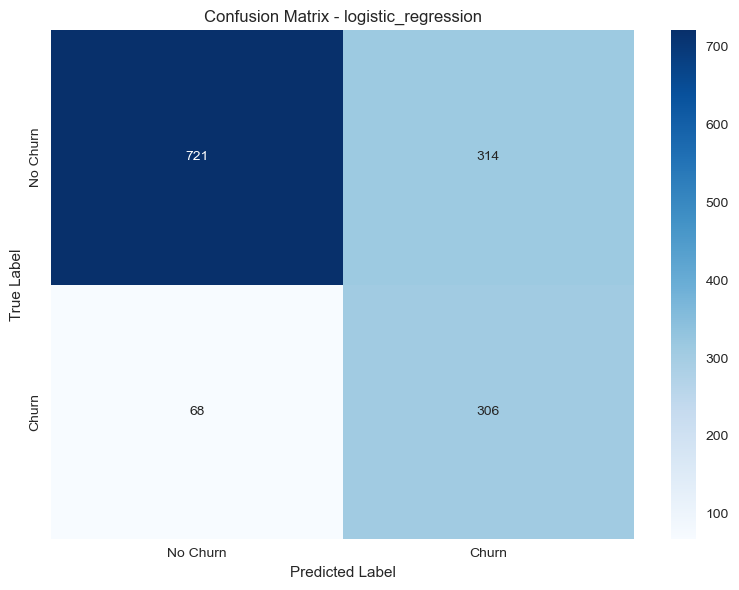

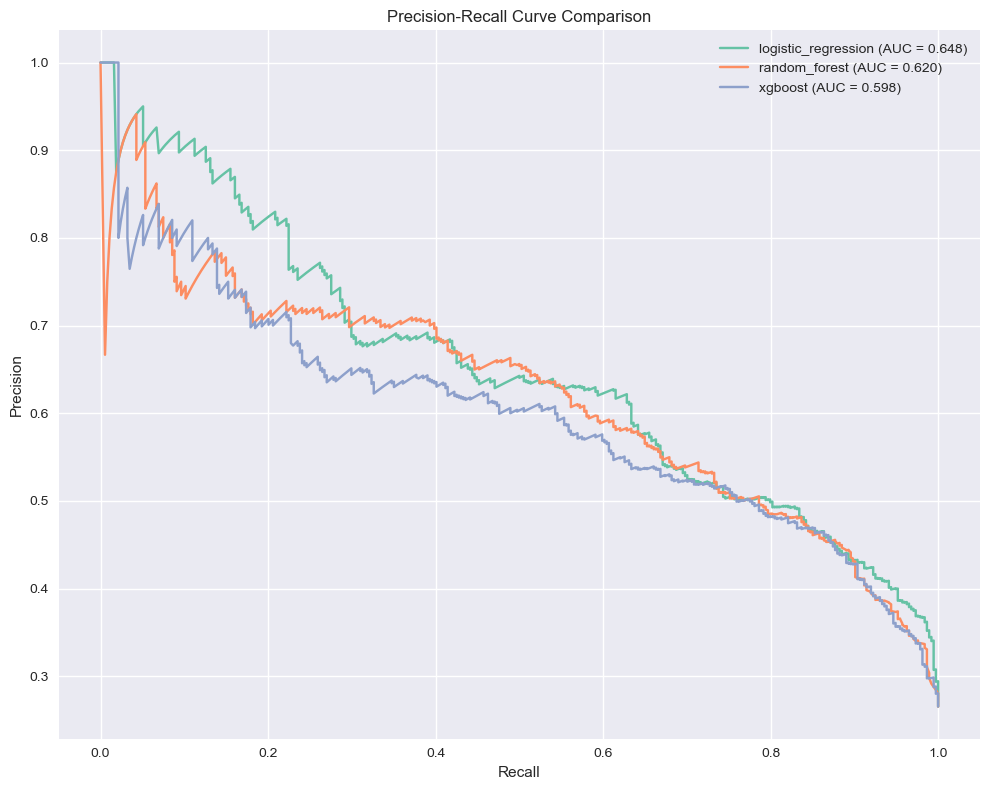


=== Threshold Optimization for logistic_regression ===
Optimal threshold: 0.25
Max F2-score: 0.7454

Performance with optimized threshold:
Recall: 0.9519
Precision: 0.3991
F2-score: 0.7454

Best model saved to '../models/best_model_logistic_regression.pkl'
Optimal threshold saved to '../models/optimal_threshold_logistic_regression.pkl'
All model results saved to '../models/all_model_results.pkl'
Detailed model comparison saved to '../results/model_comparison_detailed.csv'

=== MODEL TRAINING AND SELECTION COMPLETE ===


In [7]:
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# # Customer Churn Prediction - Model Training and Selection
# 
# This notebook focuses on training, evaluating, and selecting the best model for churn prediction.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, precision_recall_curve, auc,
                             f1_score, precision_score, recall_score, accuracy_score,
                             fbeta_score)
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
%matplotlib inline

# ## Load Processed Datasets

# Load tree models dataset (label encoded)
df_tree = pd.read_csv('../data/processed/telco_churn_tree_models.csv')
print("Tree models dataset shape:", df_tree.shape)

# Load linear models dataset (one-hot encoded)
df_linear = pd.read_csv('../data/processed/telco_churn_linear_models.csv')
print("Linear models dataset shape:", df_linear.shape)

# Check churn distribution
print("\nChurn distribution in tree dataset:")
print(df_tree['Churn'].value_counts())
print("\nChurn distribution in linear dataset:")
print(df_linear['Churn'].value_counts())

# ## Prepare Datasets for Specific Models

# For tree-based models (Random Forest, XGBoost) - use label encoded data
X_tree = df_tree.drop('Churn', axis=1)
y_tree = df_tree['Churn']

# For linear model (Logistic Regression) - use one-hot encoded data
X_linear = df_linear.drop('Churn', axis=1)
y_linear = df_linear['Churn']

# Split the data for each model type
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42, stratify=y_tree
)

X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=42, stratify=y_linear
)

print("\nTree models - Training set shape:", X_tree_train.shape)
print("Tree models - Test set shape:", X_tree_test.shape)
print("Linear models - Training set shape:", X_linear_train.shape)
print("Linear models - Test set shape:", X_linear_test.shape)

# ## Handle Class Imbalance

# Apply SMOTE to training data only for each dataset
smote = SMOTE(random_state=42)

# For tree models
X_tree_train_res, y_tree_train_res = smote.fit_resample(X_tree_train, y_tree_train)

# For linear models  
X_linear_train_res, y_linear_train_res = smote.fit_resample(X_linear_train, y_linear_train)

print("\nAfter SMOTE:")
print("Tree models - Training set shape:", X_tree_train_res.shape)
print("Linear models - Training set shape:", X_linear_train_res.shape)

# ## Model Training Setup

# Define models with their respective datasets
models = {
    'logistic_regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear']
        },
        'X_train': X_linear_train_res,
        'y_train': y_linear_train_res,
        'X_test': X_linear_test,
        'y_test': y_linear_test
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'class_weight': ['balanced']
        },
        'X_train': X_tree_train_res,
        'y_train': y_tree_train_res,
        'X_test': X_tree_test,
        'y_test': y_tree_test
    },
    'xgboost': {
        'model': xgb.XGBClassifier(
            random_state=42, 
            eval_metric='logloss',
            use_label_encoder=False
        ),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.1, 0.2],
            'scale_pos_weight': [sum(y_tree_train == 0) / sum(y_tree_train == 1)]
        },
        'X_train': X_tree_train_res,
        'y_train': y_tree_train_res,
        'X_test': X_tree_test,
        'y_test': y_tree_test
    }
}

# Use stratified cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced for speed

# ## Model Training and Tuning

results = {}

for name, model_info in models.items():
    print(f"\n=== Training {name} ===")
    print(f"Using dataset with shape: {model_info['X_train'].shape}")
    
    try:
        # Perform grid search
        grid_search = GridSearchCV(
            model_info['model'], 
            model_info['params'], 
            cv=cv, 
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(model_info['X_train'], model_info['y_train'])
        
        # Get best model
        best_model = grid_search.best_estimator_
        
        # Make predictions
        y_pred = best_model.predict(model_info['X_test'])
        y_pred_proba = best_model.predict_proba(model_info['X_test'])[:, 1]
        
        # Calculate metrics
        precision, recall, _ = precision_recall_curve(model_info['y_test'], y_pred_proba)
        pr_auc = auc(recall, precision)
        
        # Get confusion matrix
        cm = confusion_matrix(model_info['y_test'], y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Store results
        results[name] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'accuracy': accuracy_score(model_info['y_test'], y_pred),
            'roc_auc': roc_auc_score(model_info['y_test'], y_pred_proba),
            'pr_auc': pr_auc,
            'f1_score': f1_score(model_info['y_test'], y_pred),
            'precision': precision_score(model_info['y_test'], y_pred),
            'recall': recall_score(model_info['y_test'], y_pred),
            'classification_report': classification_report(model_info['y_test'], y_pred, output_dict=True),
            'confusion_matrix': cm,
            'y_pred_proba': y_pred_proba,
            'test_data': (model_info['X_test'], model_info['y_test']),
            'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
        }
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")
        print(f"Test ROC AUC: {results[name]['roc_auc']:.4f}")
        print(f"Test PR AUC: {results[name]['pr_auc']:.4f}")
        print(f"Recall: {results[name]['recall']:.4f}")
    
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        # Store error information
        results[name] = {
            'error': str(e),
            'status': 'failed'
        }

# ## Comprehensive Model Evaluation

# Calculate additional metrics and create comparison dataframe
metrics_data = []

for name, result in results.items():
    if 'error' not in result:
        metrics_data.append({
            'Model': name,
            'ROC AUC': result['roc_auc'],
            'PR AUC': result['pr_auc'],
            'F1 Score': result['f1_score'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'Accuracy': result['accuracy'],
            'True Negatives': result['tn'],
            'False Positives': result['fp'],
            'False Negatives': result['fn'],
            'True Positives': result['tp']
        })

# Create comparison dataframe
comparison = pd.DataFrame(metrics_data)

# Add business-oriented metrics
COST_FALSE_NEGATIVE = 500  # Cost of losing a customer
COST_FALSE_POSITIVE = 50   # Cost of unnecessary retention offer

for i, row in comparison.iterrows():
    fn = row['False Negatives']
    fp = row['False Positives']
    
    # Business value calculation
    business_value = - (fn * COST_FALSE_NEGATIVE + fp * COST_FALSE_POSITIVE)
    comparison.at[i, 'Business Value'] = business_value
    
    # Capture rate (percentage of churners caught)
    total_churners = row['False Negatives'] + row['True Positives']
    capture_rate = row['True Positives'] / total_churners if total_churners > 0 else 0
    comparison.at[i, 'Capture Rate'] = capture_rate

# Calculate weighted score (emphasizing recall and PR AUC)
weights = {
    'PR AUC': 0.3,    # Most important for imbalanced data
    'Recall': 0.25,   # Critical for catching churners
    'F1 Score': 0.2,  # Balance measure
    'ROC AUC': 0.15,  # General performance
    'Precision': 0.1, # Less important than recall
}

# Normalize scores and calculate weighted total
for metric, weight in weights.items():
    max_val = comparison[metric].max()
    comparison[f'{metric}_Normalized'] = comparison[metric] / max_val
    comparison[f'{metric}_Weighted'] = comparison[f'{metric}_Normalized'] * weight

comparison['Weighted Score'] = comparison[[f'{metric}_Weighted' for metric in weights.keys()]].sum(axis=1)

# Sort by multiple criteria
comparison = comparison.sort_values(['PR AUC', 'Recall', 'Weighted Score'], ascending=[False, False, False])

print("Comprehensive Model Comparison:")
pd.set_option('display.float_format', '{:.4f}'.format)
display(comparison[['Model', 'PR AUC', 'Recall', 'F1 Score', 'Precision', 'Accuracy', 
                   'Capture Rate', 'Business Value', 'Weighted Score']])

# ## Select Best Model

# Select based on multiple criteria
best_model_name = comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n=== BEST MODEL SELECTED: {best_model_name.upper()} ===")
print(f"PR AUC: {comparison.iloc[0]['PR AUC']:.4f}")
print(f"Recall: {comparison.iloc[0]['Recall']:.4f}")
print(f"Capture Rate: {comparison.iloc[0]['Capture Rate']:.2%}")
print(f"Business Value: ${comparison.iloc[0]['Business Value']:,.0f}")

# Display detailed classification report for best model
print("\nDetailed Classification Report:")
best_result = results[best_model_name]
print(pd.DataFrame(best_result['classification_report']).transpose())

# ## Visualization

# Plot confusion matrix for best model
plt.figure(figsize=(8, 6))
sns.heatmap(best_result['confusion_matrix'], 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../results/best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Precision-Recall curve for all models
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if 'error' not in result:
        precision, recall, _ = precision_recall_curve(result['test_data'][1], result['y_pred_proba'])
        plt.plot(recall, precision, label=f'{name} (AUC = {result["pr_auc"]:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../results/precision_recall_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ## Threshold Optimization for Best Model

# Find optimal threshold for business needs
print(f"\n=== Threshold Optimization for {best_model_name} ===")

y_test = best_result['test_data'][1]
y_pred_proba = best_result['y_pred_proba']

thresholds = np.arange(0.1, 0.9, 0.05)
f2_scores = []  # F2-score emphasizes recall more than F1

for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    f2_scores.append(fbeta_score(y_test, y_pred_adjusted, beta=2))

optimal_threshold = thresholds[np.argmax(f2_scores)]
print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Max F2-score: {max(f2_scores):.4f}")

# Apply optimal threshold
y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

print("\nPerformance with optimized threshold:")
print(f"Recall: {recall_score(y_test, y_pred_optimized):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimized):.4f}")
print(f"F2-score: {fbeta_score(y_test, y_pred_optimized, beta=2):.4f}")

# ## Save Best Model and Results

# Save the best model
joblib.dump(best_model, f'../models/best_model_{best_model_name}.pkl')
print(f"\nBest model saved to '../models/best_model_{best_model_name}.pkl'")

# Save optimal threshold
joblib.dump(optimal_threshold, f'../models/optimal_threshold_{best_model_name}.pkl')
print(f"Optimal threshold saved to '../models/optimal_threshold_{best_model_name}.pkl'")

# Save all results
joblib.dump(results, '../models/all_model_results.pkl')
print("All model results saved to '../models/all_model_results.pkl'")

# Save comparison table
comparison.to_csv('../results/model_comparison_detailed.csv', index=False)
print("Detailed model comparison saved to '../results/model_comparison_detailed.csv'")

print("\n=== MODEL TRAINING AND SELECTION COMPLETE ===")